  0%|          | 0/3 [00:00<?, ?it/s]

Iteration 1: Loss = 0.6387, Gradient Magnitude = 0.2097
Iteration 51: Loss = 0.2008, Gradient Magnitude = 2.5054
Iteration 101: Loss = 0.1626, Gradient Magnitude = 3.2841
Iteration 151: Loss = 0.1445, Gradient Magnitude = 3.7934
Iteration 201: Loss = 0.1330, Gradient Magnitude = 4.1886
Iteration 251: Loss = 0.1245, Gradient Magnitude = 4.5218
Iteration 301: Loss = 0.1188, Gradient Magnitude = 4.8078
Iteration 351: Loss = 0.1127, Gradient Magnitude = 5.0752
Iteration 401: Loss = 0.1088, Gradient Magnitude = 5.3314
Iteration 451: Loss = 0.1044, Gradient Magnitude = 5.5697
Degree 6: Test Accuracy = 0.9337, Validation Accuracy = 0.9293, Features = 5005


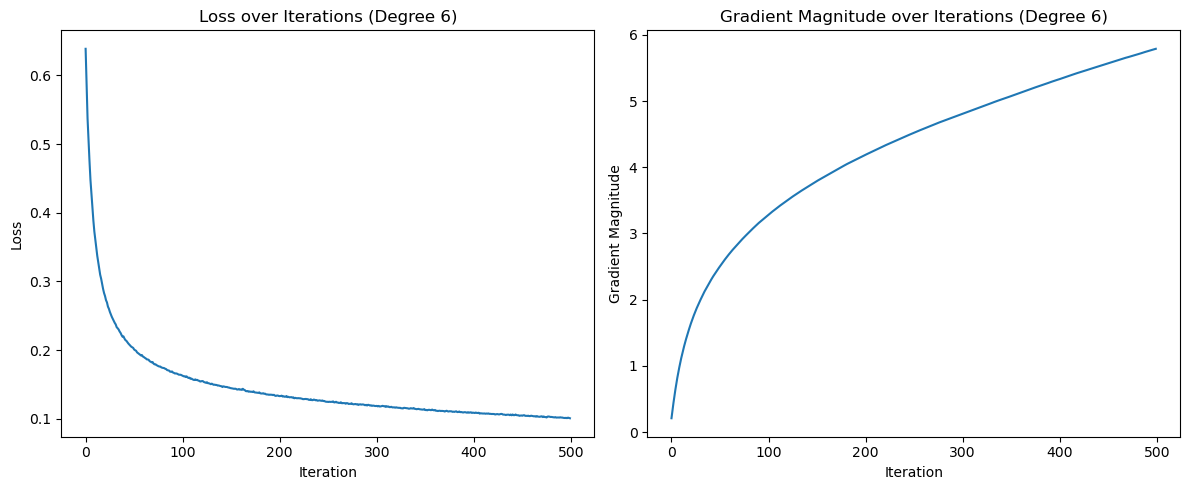

Iteration 1: Loss = 0.6685, Gradient Magnitude = 0.0756
Iteration 51: Loss = 0.3383, Gradient Magnitude = 1.1153
Iteration 101: Loss = 0.2523, Gradient Magnitude = 1.6774
Iteration 151: Loss = 0.2107, Gradient Magnitude = 2.0687
Iteration 201: Loss = 0.1860, Gradient Magnitude = 2.3655
Iteration 251: Loss = 0.1694, Gradient Magnitude = 2.6169
Iteration 301: Loss = 0.1573, Gradient Magnitude = 2.8173
Iteration 351: Loss = 0.1473, Gradient Magnitude = 3.0118
Iteration 401: Loss = 0.1389, Gradient Magnitude = 3.1908
Iteration 451: Loss = 0.1324, Gradient Magnitude = 3.3324
Degree 7: Test Accuracy = 0.9289, Validation Accuracy = 0.9285, Features = 11440


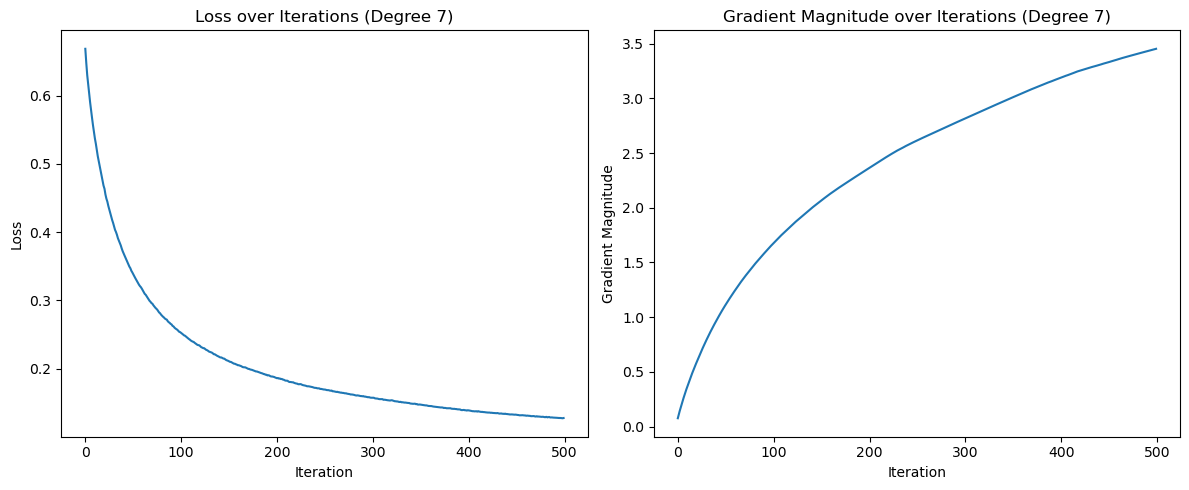

 33%|███▎      | 1/3 [09:06<18:12, 546.22s/it]

Iteration 1: Loss = 0.6773, Gradient Magnitude = 0.1728
Iteration 51: Loss = 0.4316, Gradient Magnitude = 1.5730
Iteration 101: Loss = 0.3608, Gradient Magnitude = 2.3595
Iteration 151: Loss = 0.3195, Gradient Magnitude = 2.9823
Iteration 201: Loss = 0.2873, Gradient Magnitude = 3.5168


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.linear_model")

# Define the polynomial degrees and dataset versions to test
possible_n_vals = [9, 12, 15]
possible_e_vals = [6, 7]

# Run polynomial logistic regression and observe convergence patterns
def run_poly_logistic_regression(n, e):
    X = np.load(f'Datasets/kryptonite-{n}-X.npy')
    y = np.load(f'Datasets/kryptonite-{n}-y.npy')

    # Shuffle and split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Standardize the original features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Create polynomial features of specified degree
    poly = PolynomialFeatures(degree=e)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)
    
    # Initialize logistic regression with warm start to track progress
    logreg = LogisticRegression(max_iter=1, solver='sag', C=0.85, warm_start=True)
    losses = []
    gradient_magnitudes = []
    
    # Run the model for multiple iterations and record loss and gradient magnitude
    for i in range(500):  # Simulating max_iter=500
        logreg.fit(X_train_poly, y_train)
        
        # Compute the training loss
        y_pred_prob = logreg.predict_proba(X_train_poly)[:, 1]
        loss = log_loss(y_train, y_pred_prob)
        losses.append(loss)
        
        # Compute the gradient magnitude
        grad = logreg.coef_
        grad_magnitude = np.linalg.norm(grad)
        gradient_magnitudes.append(grad_magnitude)
        
        if i % 50 == 0:
            print(f"Iteration {i + 1}: Loss = {loss:.4f}, Gradient Magnitude = {grad_magnitude:.4f}")

    # Evaluate final model on validation and test sets
    val_accuracy = accuracy_score(y_val, logreg.predict(X_val_poly))
    test_accuracy = accuracy_score(y_test, logreg.predict(X_test_poly))
    features = X_train_poly.shape[1]
    
    # Print test results for each run
    print(f"Degree {e}: Test Accuracy = {test_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}, Features = {features}")
    
    # Plot loss and gradient magnitude over iterations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(losses, label='Loss')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Loss over Iterations (Degree {e})')
    
    ax2.plot(gradient_magnitudes, label='Gradient Magnitude')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Gradient Magnitude')
    ax2.set_title(f'Gradient Magnitude over Iterations (Degree {e})')
    
    plt.tight_layout()
    plt.show()
    
    return test_accuracy, features, val_accuracy

# Store results to analyze performance vs. complexity trade-offs
acc_by_n, feat_by_n, val_acc_by_n = [], [], []
for n in tqdm(possible_n_vals):
    single_n, single_feat, single_val_acc = [], [], []
    for e in tqdm(possible_e_vals):
        test_acc, feat_count, val_acc = run_poly_logistic_regression(n, e)
        single_n.append(test_acc)
        single_feat.append(feat_count)
        single_val_acc.append(val_acc)
    acc_by_n.append(single_n)
    feat_by_n.append(single_feat)
    val_acc_by_n.append(single_val_acc)

# Print final summary of all results
for idx, n in enumerate(possible_n_vals):
    print(f"\nResults for Dataset kryptonite-{n}:")
    for degree, acc, feat, val_acc in zip(possible_e_vals, acc_by_n[idx], feat_by_n[idx], val_acc_by_n[idx]):
        print(f"Degree {degree}: Test Accuracy = {acc:.4f}, Validation Accuracy = {val_acc:.4f}, Features = {feat}")



In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from numpy.linalg import eigvals

# Define possible values for n and degree (polynomial expansion) and C
possible_n_vals = [9]
degree = 6  # Polynomial degree set to 6
possible_C_vals = [0.001,0.01, 0.1, 0.5, 0.85]  # Different C values to test

def calculate_condition_number(X_poly):
    """Calculate the condition number of the Hessian without regularization."""
    m, n = X_poly.shape
    theta = np.zeros(n)
    predictions = 1 / (1 + np.exp(-X_poly @ theta))
    D = np.diag(predictions * (1 - predictions))
    H = X_poly.T @ D @ X_poly / m  # Hessian without regularization
    eigenvalues = eigvals(H)
    condition_number = np.abs(eigenvalues.max()) / np.abs(eigenvalues.min())
    return condition_number

def run_poly_logistic_regression(n, C_val):
    # Load dataset
    X = np.load(f'Datasets/kryptonite-{n}-X.npy')
    y = np.load(f'Datasets/kryptonite-{n}-y.npy')

    # Split data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Standardize the data before polynomial expansion
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Create polynomial features of specified degree
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    # Calculate the condition number without regularization
    condition_number_no_reg = calculate_condition_number(X_train_poly)

    # Initialize and fit logistic regression with the given C value
    logreg = LogisticRegression(max_iter=500, solver='sag', C=C_val)
    logreg.fit(X_train_poly, y_train)

    # Calculate the condition number with regularization (approximation)
    H_reg = X_train_poly.T @ np.diag(logreg.predict_proba(X_train_poly)[:, 1] * 
                                     (1 - logreg.predict_proba(X_train_poly)[:, 1])) @ X_train_poly / X_train_poly.shape[0] + (1 / C_val) * np.eye(X_train_poly.shape[1])
    eigenvalues_reg = eigvals(H_reg)
    condition_number_with_reg = np.abs(eigenvalues_reg.max()) / np.abs(eigenvalues_reg.min())

    # Evaluate on the validation set
    y_val_pred = logreg.predict(X_val_poly)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Evaluate on the test set
    y_test_pred = logreg.predict(X_test_poly)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print results for the current C value
    print(f"C = {C_val}")
    print(f"Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"Condition Number without Regularization: {condition_number_no_reg:.4f}")
    print(f"Condition Number with Regularization (C={C_val}): {condition_number_with_reg:.4f}\n")

    return test_accuracy, condition_number_with_reg

# Run the experiment
for n in possible_n_vals:
    print(f"\nDataset kryptonite-{n}, Polynomial Degree {degree}")
    for C_val in possible_C_vals:
        run_poly_logistic_regression(n, C_val)



Dataset kryptonite-9, Polynomial Degree 6
C = 0.001
Validation Accuracy: 0.9422, Test Accuracy: 0.9476
Condition Number without Regularization: 2035414806411.9619
Condition Number with Regularization (C=0.001): 1.0406

C = 0.01
Validation Accuracy: 0.9457, Test Accuracy: 0.9483
Condition Number without Regularization: 2035414806411.9619
Condition Number with Regularization (C=0.01): 1.1718



/Users/faizajalil/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C = 0.1
Validation Accuracy: 0.9335, Test Accuracy: 0.9378
Condition Number without Regularization: 2035414806411.9619
Condition Number with Regularization (C=0.1): 2.0831



/Users/faizajalil/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C = 0.5
Validation Accuracy: 0.9322, Test Accuracy: 0.9359
Condition Number without Regularization: 2035414806411.9619
Condition Number with Regularization (C=0.5): 5.8407



/Users/faizajalil/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C = 0.85
Validation Accuracy: 0.9319, Test Accuracy: 0.9357
Condition Number without Regularization: 2035414806411.9619
Condition Number with Regularization (C=0.85): 9.2293



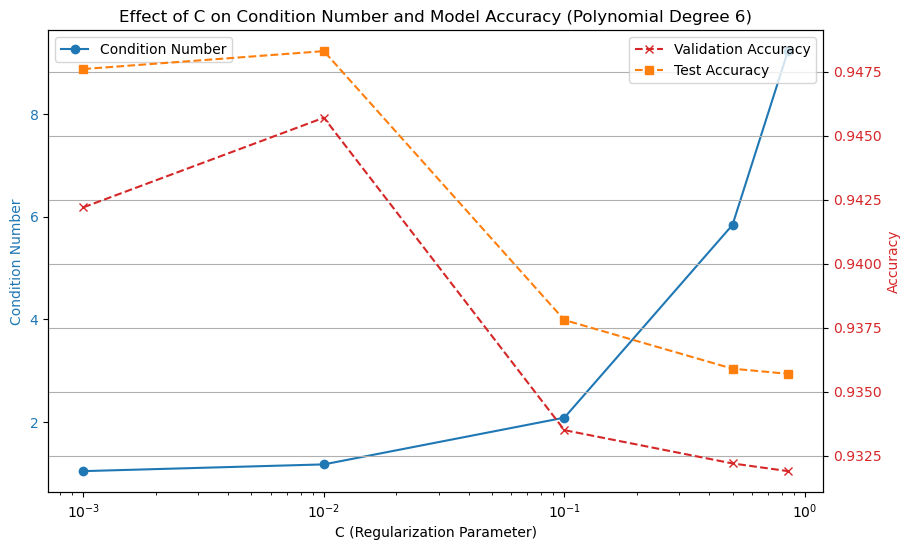

In [7]:
import matplotlib.pyplot as plt

# Data: values of C, condition numbers with regularization, validation accuracy, and test accuracy
C_vals = [0.001, 0.01, 0.1, 0.5, 0.85]
condition_numbers = [1.0406, 1.1718, 2.0831, 5.8407, 9.2293]
validation_accuracies = [0.9422, 0.9457, 0.9335, 0.9322, 0.9319]
test_accuracies = [0.9476, 0.9483, 0.9378, 0.9359, 0.9357]

# Plot Condition Number vs. C values
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('C (Regularization Parameter)')
ax1.set_ylabel('Condition Number', color=color)
ax1.plot(C_vals, condition_numbers, color=color, marker='o', label='Condition Number')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(C_vals, validation_accuracies, color='tab:red', marker='x', linestyle='--', label='Validation Accuracy')
ax2.plot(C_vals, test_accuracies, color='tab:orange', marker='s', linestyle='--', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Add legends for each axis
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Effect of C on Condition Number and Model Accuracy (Polynomial Degree 6)")
plt.grid()
plt.show()


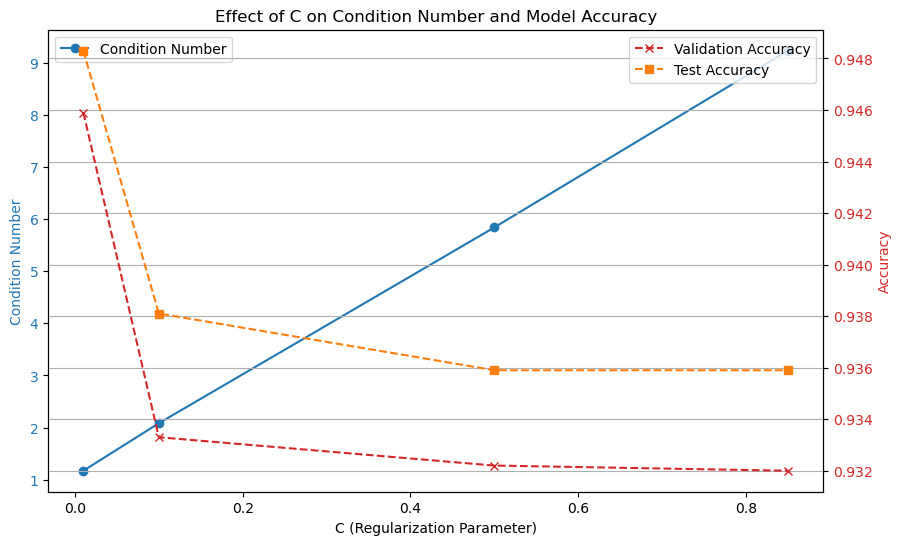

In [3]:
import matplotlib.pyplot as plt

# Data: values of C, condition numbers with regularization, validation accuracy, and test accuracy
C_vals = [0.01, 0.1, 0.5, 0.85]
condition_numbers = [1.1718, 2.0832, 5.8401, 9.2290]
validation_accuracies = [0.9459, 0.9333, 0.9322, 0.9320]
test_accuracies = [0.9483, 0.9381, 0.9359, 0.9359]

# Plot condition number vs. C values
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('C (Regularization Parameter)')
ax1.set_ylabel('Condition Number', color=color)
ax1.plot(C_vals, condition_numbers, color=color, marker='o', label='Condition Number')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(C_vals, validation_accuracies, color='tab:red', marker='x', linestyle='--', label='Validation Accuracy')
ax2.plot(C_vals, test_accuracies, color='tab:orange', marker='s', linestyle='--', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend for each axis
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Effect of C on Condition Number and Model Accuracy")
plt.xscale('log')  # Log scale for C values to show the impact more clearly
plt.grid()
plt.show()
